## Testing and Characterizing the Linker

We have several goals here:
 * Define a useful sample of fakes
 * Run linker
 * Identify triplets and work out ways of adding points efficiently
 * Compare detected objects to input fake catalog

As out initial sample, we'll use simulated detections of fake TNOs, all with a=40AU, in the Y1 X-fields.
We won't worry about simulating magnitudes or single-epoch detection efficiencies for now; initial goal is just geometric properties of the linker. Want to make sure we can efficiently detect objects with weird orbits (e.g. retrograde), and objects which graze or cross fields.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
from __future__ import division
import numpy as np
import pandas as pd
from KBO import *
from DESKBO import DEScands
import matplotlib.pyplot as plt

### Fake catalogs:

*Here is a running list of fake catalogs generated so far:*

Category | Field | Season | fake bodies | observations | generation parameters
--- | --- | --- | --- | --- | --- 
Sednoids | S1 | Y1 | `fakes_200_500_AU_S1.csv` | `fake_detections_200_500_AU_S1_Y1.csv` | $200<a<500$, $10<i<120$, $0<H<3$, peri>70, $0.55<e<0.95$
Classical/Scattered | S1 | Y1 | `fakes_40_50_AU_S1.csv` | `fake_detections_40_50_AU_S1_Y1.csv` | $40<a<50$, $10<i<120$, $4<H<8$, peri>30, $e<0.25$

#### Open the fake catalogs. The first is the truth, with fakeids and orbital elements.  The second is the Y1 detections.

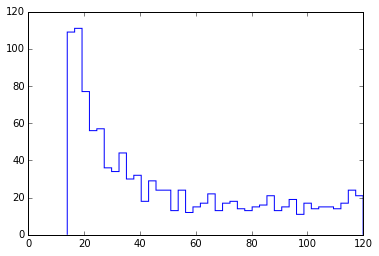

In [28]:
target='S1'
truth_in = 'fakes_40_50_AU_S1.csv'
fakes_det_in = 'fake_detections_40_50_AU_S1_Y1.csv'
fakes_truth = pd.read_csv(truth_in) 
fakes_det = pd.read_csv(fakes_det_in)
n, bins, patches = plt.hist(fakes_truth.i, bins=40, histtype='step', color='b')

In [29]:
# Create the input catalog

fake_cat = Catalog(rows=fakes_det_in,fakeid=int,date_obs=str,expnum=int,exptime=float, 
                   ra=float,dec=float,band=str,ccdnum=int,nite=int,objid=int)
fake_cat.rename(date='date_obs', ccd='ccdnum')
fake_cat.refactor('date',toDateTime)
fake_cat.refactor('ra',  lambda ra: hours(ra))
fake_cat.refactor('dec', lambda dec: degrees(dec))

Now let's define the notion of a "detectable fake", an object that's present in the same field on three different visits. (This definition will eventually evolve to include objects that cross fields.)

In [30]:
# returns a list of the fields that a given point is in.
def get_field(point):
    in_fields = []
    for field in fields:
#        print field.name, point.ra, point.dec, field.center.ra, field.center.dec
        ccdName, ccdNum = compute_chip(point.ra, point.dec, field.center.ra, field.center.dec) 
        if ccdNum>-99: in_fields.append(field.name)
    return in_fields

In [31]:
# Utility to return the list of nites a given fake_id was observed in a given field
def get_nites(fake_cat, fake_id, field):
    this_fake = [p for p in fake_cat if p.fakeid==fake_id and field in get_field(p)]    # observations matching this fake
    nites = sorted(set([p.nite for p in this_fake]))
    return nites

In [32]:
# defines a "detectable fake"
def isDetectable(fake_cat, fake_id, field):
    return True if len(get_nites(fake_cat, fake_id, field))>2 else False

#### It would be interesting to convert the linker from using Catalog objects to pandas dataframes, which seem to have all the functionality (and more) of Catalogs, and are probably much faster. But for this initial test, and to establish a baseline, let's read the detected objects into a Catalog and use the original linker.

In [33]:
astrometric_err = 0.2
linkstuff = []    # some internals from the linker, for examination and debugging.

class ObjectLinker(object):
    def __init__(self, target, objcat, band = None, exclude_snobjids=None, date_start=None, look_ahead_visits=2):

# objcat is a Catalog (for now) which must contain at least the following columns:
#     date (as a DateTime object)
#     nite
#     ra, dec in radians or ephem.Angle objects
#     band
#     expnum
#     exptime (in seconds)
#     objid (a unique identifier, such as snobjid)
#     mag
#     ccd
        self.objects = objcat
        if band is not None: self.objects = Catalog(obj for obj in self.objects if obj.band == band)
        if exclude_snobjids is not None: self.objects = Catalog(obj for obj in self.objects if obj.objid not in exclude_snobjids)
#
        if date_start is not None: self.objects = Catalog(obj for obj in self.objects if obj.date>=date_start)
        self.objects.add_constant('obscode', 807)
        self.objects.add_constant('err', astrometric_err)
        self.objects.orderby('date')
        self.field = fields[target]
        self.band = band
        self.look_ahead_visits = look_ahead_visits   # how many visits to look ahead for linking
        
    def sep(self, point1, point2):
        # returns separation between two points in arcsec
        return ephem.separation((point1.ra, point1.dec), (point2.ra, point2.dec))*180/np.pi*3600
        
    def link(self, objid):

        # get the object associated with this objid
        point = self.objects[objid]
        
        # link object and return
        next_objid = link_obj(point)
        return next_objid
       
    def link_obj(self, point):
        visits = self.field.visits
        visits.orderby('nite')
        thisvisit = visits[point.nite]
        if thisvisit is None:
            print 'This point\'s visit not found!'
            print point.date
            return []
        nextvisit = thisvisit
        next_obj = []
        for i in range(self.look_ahead_visits):
            
            # get the next visit
            try:
                nextvisit = next(visit for visit in visits if visit.nite > nextvisit.nite)
            except StopIteration: pass
            if nextvisit is None: 
                print "nextvisit is None!"
                return []
            
            current_objects = [obj for obj in self.objects if obj.nite == nextvisit.nite \
                               and (self.band is None or obj.band == self.band) ]
            # now the real work: for each object, test to see
            # if it's consistent with being the next point in
            # a KBO trajectory.
            lon, lat = Ecliptic(Equatorial(point.ra, point.dec)).get()
            centerlat = Ecliptic(Equatorial(self.field.center)).lat
            for obj in current_objects:
                objlon, objlat = Ecliptic(Equatorial(obj.ra, obj.dec)).get()
                dlon, dlat = nextvisit.dlon - thisvisit.dlon, nextvisit.dlat - thisvisit.dlat
                displacement = ephem.separation((objlon, objlat), (lon, lat))
                norm = np.sqrt(np.cos(centerlat)**2*dlon**2 + dlat**2)
                dot = np.cos(centerlat)**2*(objlon - lon)*dlon + (objlat - lat)*dlat
                if obj.date != point.date:
                     velocity = displacement/(obj.date - point.date)
                else: 
                     break
                cosine = dot/(norm*displacement)
                linkstuff.append(
                    dict([('cos',cosine),('objid', obj.objid),('velocity',velocity),
                         ('dlon',dlon), ('dlat',dlat), ('displacement',displacement),
                         ('norm',norm),('dot',dot),('objdlon',objlon-lon),('objdlat',objlat-lat)]
                        ))
                if cosine > np.cos(20 * np.pi/180) and velocity < 150 * np.pi/(180*3600): # arcsec/day
                    next_obj.append(obj)
        return next_obj

In [34]:
# Gets the nites associated with each exposure if not present in y in our input catalog.
# Requires a database connection.
def query_nites(cat_in):
    nites={}
    expnites={}
    exps = sorted(set([p.expnum for p in cat_in]))
    cursor=db_connect()
    for exp in exps:
        query = 'select e.nite from exposure e where e.expnum = '+str(exp)
        cursor.execute(query)
        rows = cursor.fetchall()
        expnites[exp]=int(rows[0][0])
    for p in cat_in:
        nites[p]=expnites[p.expnum]
    return nites

In [35]:
fake_ids = sorted(set([p.fakeid for p in fake_cat]))
print len(fake_ids)

707


## Carry out the linking à la linkfit2.py

In [36]:
def do_link(linker):
    good_triplets = []
    cat1 = linker.objects
    for obj1 in cat1:
        next_points = linker.link_obj(obj1)
        for obj2 in next_points:
#            print '.',
            next_next_points = linker.link_obj(obj2)
            for obj3 in next_next_points:
                triple=Catalog([obj1, obj2, obj3])
#                print '-',
                orbit = Orbit(triple)
                if orbit.chisq<2 and orbit.elements['a']>20:    # good triplet
                      good_triplets.append(triple)
#    print
    return good_triplets

### Now what to do with all these triplets? Let's try to grow triplets by adding points that occur in multiple triplets.

For the moment: assume we will find some efficient and elegant way of consolidating the triplets from a given object. In the mean time, just combine all the points from the triplets associated with a given object into one set of observations, and re-fit.

In [37]:
def merge_triplets(good_triplets):
    allobs = Catalog(set([obs for triplet in good_triplets for obs in triplet]))
    allobs.orderby('date')
    return allobs

#### Choose field and carry out linking object by object

In [38]:
orbits = []
truth = []
found_truth = []
not_found_truth = []
not_found_ids = []
first_nite_found = []
first_nite_not_found = []
# Make sure our fake catalog contains points from this field's nites only
our_nites = [v.nite for v in fields[target].visits]
fake_cat = Catalog([p for p in fake_cat if p.nite in our_nites])
for fakeid in fake_ids:
#    print 'Processing fakeid... ', fakeid
    if isDetectable(fake_cat, fakeid, target):
        df_true = fakes_truth.loc[fakes_truth['fakeid'] == fakeid]    # dataframe from truth catalog
        truth.append(df_true.iloc[0])    # pandas series representing this single row of the table
        this_fake_cat = Catalog([p for p in fake_cat if p.fakeid==fakeid and p.band=='r'])
        this_fake_cat.orderby('date')
#        for p in this_fake_cat:
#            print p.date,',', p.ra, ',',p.dec, ',',p.expnum,',', p.exptime,',', p.band,',', p.ccd 
        linker = ObjectLinker(target, this_fake_cat, look_ahead_visits=2)
        good_triplets = do_link(linker)
        allobs = merge_triplets(good_triplets)
        if len(allobs)>2: 
            found_truth.append(df_true.iloc[0])
            orbits.append(Orbit(allobs))
            first_nite_found.append([p.date for p in this_fake_cat][0])
        else:
            not_found_ids.append(fakeid) 
            not_found_truth.append(df_true.iloc[0])
            first_nite_not_found.append([p.date for p in this_fake_cat][0])

In [41]:
a_true = [t.a for t in truth]
e_true = [t.e for t in truth]
i_true = [t.i for t in truth]
lan_true = [t.lan for t in truth]
#a_recon = [o.elements['a'] for o in orbits]
#e_recon = [o.elements['e'] for o in orbits]
#i_recon = [o.elements['i'] for o in orbits]
#lan_recon = [o.elements['lan'] for o in orbits]
a_recon = [t.a for t in found_truth]
e_recon = [t.e for t in found_truth]
i_recon = [t.i for t in found_truth]
lan_recon = [t.lan for t in found_truth]
print len(a_true), len(a_recon)


665 653


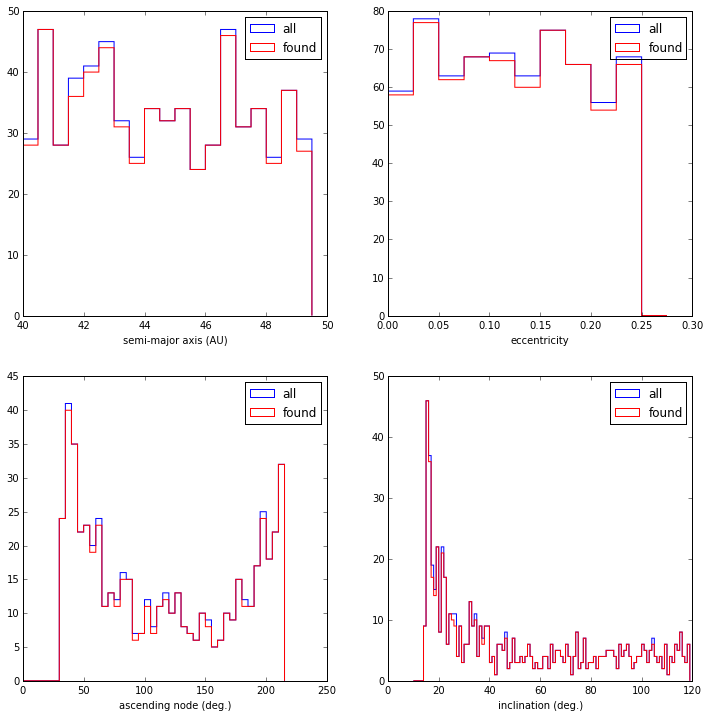

In [44]:
fig = plt.figure(1, figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
bins=np.arange(40,50,0.5)
n,bins,patches = ax1.hist(a_true, bins=bins, histtype='step', color='b', label='all')
n,bins,patches = ax1.hist(a_recon, bins=bins, histtype='step', color='r', label='found')
ax1.set_xlabel('semi-major axis (AU)')
plt.legend()

ax2 = fig.add_subplot(2,2,2)
bins=np.arange(0.,0.3,0.025)
n,bins,patches = ax2.hist(e_true, bins=bins, histtype='step', color='b', label='all')
n,bins,patches = ax2.hist(e_recon, bins=bins, histtype='step', color='r', label='found')
ax2.set_xlabel('eccentricity')
plt.legend()

ax3 = fig.add_subplot(2,2,3)
bins=np.arange(0,220,5)
n,bins,patches = ax3.hist(lan_true, bins=bins, histtype='step', color='b', label='all')
n,bins,patches = ax3.hist(lan_recon, bins=bins, histtype='step', color='r', label='found')
ax3.set_xlabel('ascending node (deg.)')
plt.legend()

ax4 = fig.add_subplot(2,2,4)
bins=np.arange(10,120,1)
ntrue,bins,patches = ax4.hist(i_true, bins=bins, histtype='step', color='b', label='all')
nrecon,bins,patches = ax4.hist(i_recon, bins=bins, histtype='step', color='r', label='found')
ax4.set_xlabel('inclination (deg.)')
plt.legend()
plt.savefig('fake_recon.pdf')
plt.show()


So far this is good news... only 5 of 256 potentially reconstructable objects were not found. Next we'll look into why, and then start adding more realism to the linker, such as: smearing observations with the astrometric error, adding noise points, developing a real procedure to merge triplets, etc.

In [45]:
# This filters the pandas dataframe containing the truth table to select the objects that were not found.
df_not_found = fakes_truth[fakes_truth['fakeid'].isin(not_found_ids)]
#df_not_found

# They look fairly unremarkable.

In [46]:
# What were their "observations"?
df = fakes_det[fakes_det['fakeid'].isin(not_found_ids)]   # filter on fakeids of objects not found
obs_not_found= df[df['band']=='r'].sort(['fakeid','date_obs'],ascending=[True,True])  # select r-band, sort by fakeid and date.
#obs_not_found

# So what they have in common is that they all entered the field late in the season, when motion
# is at a turning point from retrograde to prograde. Maybe the geometrical extrapolations in the linker 
# break down then. (NB, ccd's 31, 38 are at the easternmost edge of the focal plane.)

In [47]:
for p in fake_cat[:10]:
    print p.objid

0
1
2
3
4
5
6
7
8
9


So let's use the kinematic/geometrical information we've pulled out of the linker to see why we're missing these triplets. 

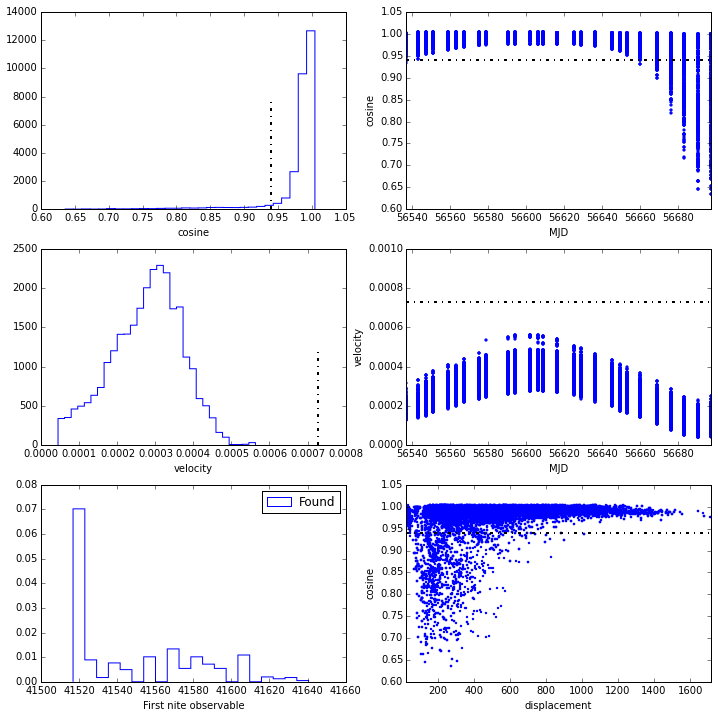

In [50]:
fig=plt.figure(2,figsize=(12,12))
ax = fig.add_subplot(3,2,1)
cos_list = [c['cos'] for c in linkstuff]
vel_list = [c['velocity'] for c in linkstuff]
norm_list = [c['norm'] for c in linkstuff]
displacement_list = 3600*180/np.pi*np.array([c['displacement'] for c in linkstuff])
dot_list =  [c['dot'] for c in linkstuff]
obj_dlon = [c['objdlon'] for c in linkstuff]
obj_dlat = [c['objdlat'] for c in linkstuff]
exp_dlon = [c['dlon'] for c in linkstuff]
exp_dlat = [c['dlat'] for c in linkstuff]
mjd_list = []
for c in linkstuff:
    objid = c['objid']
    this_obs = fakes_det.iloc[objid]
    mjd_list.append(this_obs.mjd_obs)
n,bins,patches = ax.hist(cos_list, bins=30, histtype='step')
ax.plot([np.cos(20 * np.pi/180),np.cos(20 * np.pi/180)],[0,8000],lw=2,ls='-.',color='k')
ax.set_xlabel('cosine')

ax = fig.add_subplot(3,2,2)
ax.scatter(mjd_list, cos_list, s=5,color='b')
mjd_min=sorted(mjd_list)[0]
mjd_max=sorted(mjd_list)[-1]
ax.plot([mjd_min, mjd_max],[np.cos(20 * np.pi/180),np.cos(20 * np.pi/180)],lw=2,ls='-.',color='k')
ax.set_xlim([mjd_min, mjd_max])
ax.set_xlabel('MJD')
ax.set_ylabel('cosine')


ax = fig.add_subplot(3,2,3)
n, bins, patches = ax.hist(vel_list, bins=30, histtype='step')
v_cut = 150 * np.pi/648000
ax.plot([v_cut, v_cut],[0,1200],lw=2,ls='-.',color='k')
ax.set_xlabel('velocity')

ax = fig.add_subplot(3,2,4)
ax.scatter(mjd_list, vel_list, s=5,color='b')
mjd_min=sorted(mjd_list)[0]
mjd_max=sorted(mjd_list)[-1]
ax.plot([mjd_min, mjd_max],[v_cut, v_cut],lw=2,ls='-.',color='k')
ax.set_xlim([mjd_min, mjd_max])
ax.set_ylim([0,0.001])
ax.set_xlabel('MJD')
ax.set_ylabel('velocity')

ax = fig.add_subplot(3,2,5)
n, bins, patches = ax.hist(first_nite_found, bins=20, histtype='step', color='b',label='Found',normed=True )
#n, bins, patches = ax.hist(first_nite_not_found, bins=20, histtype='step', color='r',label='Not Found',normed=True )
plt.legend()
ax.set_xlabel('First nite observable')

ax = fig.add_subplot(3,2,6)
d_min, d_max = sorted(displacement_list)[0], sorted(displacement_list)[-1]
ax.scatter(displacement_list, cos_list, s=2,color='b')
ax.set_xlim([d_min, d_max])
ax.plot([d_min,d_max],[np.cos(20 * np.pi/180),np.cos(20 * np.pi/180)],lw=2,ls='-.',color='k')
ax.set_xlabel('displacement')
ax.set_ylabel('cosine')

plt.show()

So the issue is that the cosine cut made in the linker does not match well to the late-season motion. The velocity cut looks OK. Need to deep-dive into the linker to see what's going on.

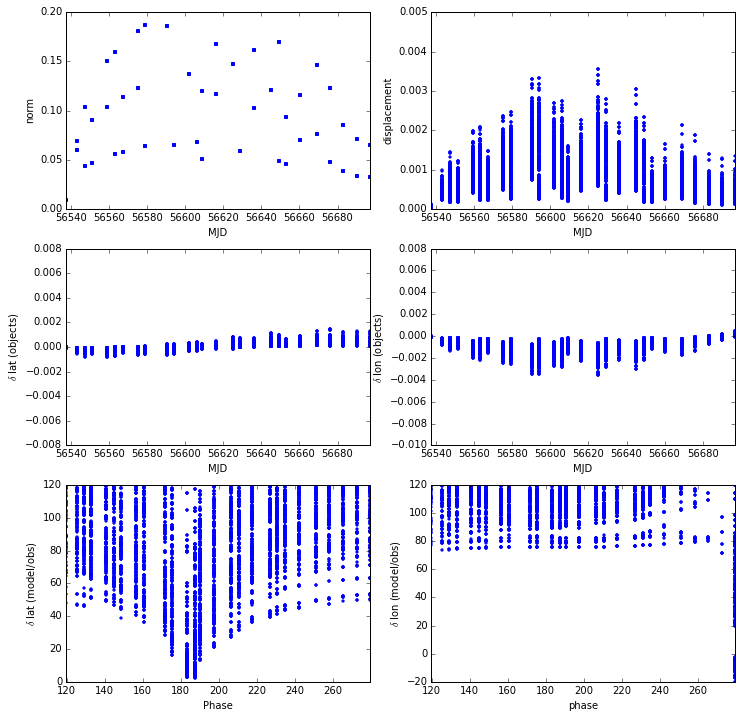

In [20]:
phase_list = []
sun = ephem.Sun()
for field in fields:
    if field.name==target:
        target_lon = Ecliptic(field.center).lon
for d in mjd_list:
    djd = d-15019.5
    sun.compute(djd)
    sun_lon, sun_lat = Ecliptic(Equatorial(sun.a_ra, sun.a_dec)).get()
    angle = (sun_lon-target_lon)*180/np.pi
    phase_list.append(angle)
phase_min=sorted(phase_list)[0]
phase_max=sorted(phase_list)[-1]
fig=plt.figure(3,figsize=(12,12))

ax = fig.add_subplot(3,2,1)
ax.scatter(mjd_list, norm_list, s=5,color='b')
mjd_min=sorted(mjd_list)[0]
mjd_max=sorted(mjd_list)[-1]
ax.set_xlim([mjd_min, mjd_max])
ax.set_ylim([0,0.2])
ax.set_xlabel('MJD')
ax.set_ylabel('norm')

ax = fig.add_subplot(3,2,2)
ax.scatter(mjd_list, displacement_list, s=5,color='b')
ax.set_xlim([mjd_min, mjd_max])
ax.set_ylim([0,0.2/40])
ax.set_xlabel('MJD')
ax.set_ylabel('displacement')

ax = fig.add_subplot(3,2,3)
ax.scatter(mjd_list, np.array(obj_dlat), s=5,color='b')
ax.set_xlim([mjd_min, mjd_max])
ax.set_xlabel('MJD')
ax.set_ylabel('$\delta$ lat (objects)')

ax = fig.add_subplot(3,2,4)
ax.scatter(mjd_list, np.array(obj_dlon), s=5,color='b')
ax.set_xlim([mjd_min, mjd_max])
ax.set_xlabel('MJD')
ax.set_ylabel('$\delta$ lon (objects)')

ax = fig.add_subplot(3,2,5)
ax.scatter(phase_list, np.array(exp_dlat)/np.array(obj_dlat), s=5,color='b')
ax.set_xlim([phase_min, phase_max])
ax.set_ylim([0,120])
ax.set_xlabel('Phase')
ax.set_ylabel('$\delta$ lat (model/obs)')

ax = fig.add_subplot(3,2,6)
ax.scatter(phase_list, np.array(exp_dlon)/np.array(obj_dlon), s=5,color='b')
ax.set_xlim([phase_min, phase_max])
ax.set_ylim([-20,120])
ax.set_xlabel('phase')
ax.set_ylabel('$\delta$ lon (model/obs)')

plt.show()


I think here is the rub. Given an initial point $p$ from a given visit, and a candidate point $q$ being evaluated from a subsequent visit, the linker does the following:

 * Compute the expected change in ecliptic coordinates for a hypothetical stationary object in the given field on the given date. This is done with the `anomalies` function in `KBO.py`. Call this vector $\vec{v}_{model}=(\delta\lambda_{model}$, $\delta\beta_{exp})$. Note that this is scaled to an object at 1 AU. The magnitude of this vector is called `norm` in the code. (Upper left plot.)
 * Compute the actual difference in ecliptic coords between $p$ and $q$. Call this vector $\vec{v}_{obs}=(\delta\lambda_{obs}$, $\delta\beta_{obs})$. The magnitude of this vector (i.e. the actual separation of the two points on the sky) is called `displacement` in the code. (Upper right plot.) Notice the difference in vertical scales of the two upper plots. The objects being linked here are at $\sim$40 AU, so the displacement is correspondingly smaller. 0.05/40 = 0.0125.
 * I am not sure why the `norm` and `displacement` plots are as discontinuous as they appear. `norm`, in particular, has nothing to do with individual objects; it depends only on visits. I guess the issue is the variable time between visits.
 * Compute the dot product:
 $$
       \vec{v}_{model}\cdot\vec{v}_{obs} = \mathrm{(norm)}\mathrm{(displacement)}\cos\theta
 $$
 * Hence $\cos\theta =$ `dot`/(`norm`*`displacement`). The linker somewhat arbitrarily requires this to be greater than $\cos 20^{\circ}$.
 * The middle two plots show the difference in lat and long between adjacent visits for object points, i.e. the components of $\vec{v}_{obs}$.
 * The bottom two plots show the *ratios* $\delta\beta_{model}/\delta\beta_{exp}$ and $\delta\lambda_{model}/\delta\lambda_{exp}$. All is OK if these are flat; normalization differences will scale out. But in the lower right plot we see a problem in the late-season behavior of this ratio for the ecliptic longitude motion. 
 * I think the issue is that the object is at a turning point here, so motion in ecliptic longitude is very small. We are trying to look for an alignment between two vectors with different lengths but nominally similar directions. But when one component vanishes or nearly does, it injects noise into the calculation and causes the point to fail the cosine cut.

Linker code, for reference:

            for obj in current_objects:
                objlon, objlat = Ecliptic(Equatorial(obj.ra, obj.dec)).get()
                dlon, dlat = nextvisit.dlon - thisvisit.dlon, nextvisit.dlat - thisvisit.dlat
                displacement = ephem.separation((objlon, objlat), (lon, lat))
                norm = np.sqrt(np.cos(centerlat)**2*dlon**2 + dlat**2)
                dot = np.cos(centerlat)**2*(objlon - lon)*dlon + (objlat - lat)*dlat
                if obj.date != point.date:
                     velocity = displacement/(obj.date - point.date)
                else: 
                     break
                cosine = dot/(norm*displacement)
                linkstuff.append(
                    dict([('cos',cosine),('objid', obj.objid),('velocity',velocity),
                         ('dlon',dlon), ('dlat',dlat), ('displacement',displacement),
                         ('norm',norm),('dot',dot),('objdlon',objlon-lon),('objdlat',objlat-lat)]
                        ))
                if cosine > np.cos(20 * np.pi/180) and velocity < 150 * np.pi/(180*3600): # arcsec/day
                    next_obj.append(obj)